# Using all three

In [111]:
import numpy as np
from numpy.random import RandomState
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import os
import random as rd
from IPython.display import clear_output

import matplotlib.pyplot as plt

In [112]:
rng = RandomState(666)
rd.seed(42)

In [113]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return 1 / (np.exp(x)+np.exp(-x)+1)

def relu(x):
    return np.maximum(0,x)

def relu_derivative(x):
    return np.where(x>0,1,0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1-np.tanh(x)**2

In [114]:
# Xavier initialization function to not have weight too small that can cause instability
def xavier_init(size_in, size_out, random_state = None):
    rng = random_state
    limit = np.sqrt(6 / (size_in + size_out))
    return rng.uniform(-limit, limit, (size_in, size_out))

def Loading(tx):
    # clear_output(wait=True)
    Loadingbar = ''.join(["=" if (i < int(tx*100)) else " " for i in range(100)])
    print("[" + "\033[32m" +  Loadingbar +'\033[0m' + "]")

def Accuracy(Nw,X,Y):
    predictions = Nw.forward(X)
    return round(np.mean((Y -predictions)**2 <= (0.05)**2),2) + 0.01*round(np.mean((Y -predictions)**2 <= (0.02)**2),2) #, np.mean([round(Y[i],1)==round(predictions[i],1) for i in range(len(Y))])

In [115]:
class Activation_Function:
    
    def __init__(self,func,func_derivative, name = None):
        self.func = func
        self.derivative = func_derivative
        self.name = name 
        


class Layer:
    def __init__(self,in_size,out_size, random_state = None):
        rng = random_state if random_state else np.random #setting the random seed instance for stability and reproductibility
        
        self.weights = xavier_init(in_size, out_size, random_state = rng)#np.random.randn(in_size,out_size) #xavier_init(in_size, out_size)
        self.bias = np.zeros((1,out_size))
        #self.delta = np.zeros((19,1))

    def Calculate_error(self, out_weights,out_delta,activation_derivative):

        self.delta =  out_delta.dot(out_weights.T) * activation_derivative(self.output)
        return self.delta

    def Calculate_output_error(self,y,output,activation_derivative):
        ### Only use if the layer is the output layer (might do a separate func one day)
        self.delta = (y-output)*activation_derivative(output)
        return self.delta

    def update(self,error, inputs, learning_rate):
        self.weights += inputs.T.dot(error) * learning_rate
        self.bias += np.sum(self.delta, axis=0, keepdims=True) * learning_rate

    def forward(self, activation, X):
        self.inputs = np.dot(X,self.weights) + self.bias
        self.output = activation(self.inputs)
        return self.output


class Network:
    def __init__(self,input_size,hidden_sizes:list,output_size,Name = "Network", random_state = None,activations = []):
        self.name = Name
        self.random_state = random_state
        
        # Initializing layers
        self.hidden_layers = [Layer(input_size,hidden_sizes[0], random_state = random_state)]
        for i in range(1,len(hidden_sizes)) :
            self.hidden_layers.append(Layer(hidden_sizes[i-1],hidden_sizes[i], random_state = random_state))
        self.output_layer = Layer(hidden_sizes[-1],output_size, random_state = random_state)      

        self.out_delta = 0
        self.hidden_deltas = [0 for d in self.hidden_layers]

        self.activations = activations

        assert len(self.activations)==len(self.hidden_layers),"Number of activation functions does not match number of hidden layers"    
    

    def forward(self,X):
        Y = self.hidden_layers[0].forward(self.activations[0].func,X)
        for i in range(1,len(self.hidden_layers)):
            Y = self.hidden_layers[i].forward(self.activations[i].func,Y)

        self.output_layer.forward(relu,self.hidden_layers[-1].output)

        self.output = self.output_layer.output

        return self.output_layer.output
    
    def loss(self,y,output):
        return (y-output)#/(abs(y-output))#**0.5

    

    def learn(self,X,y,learning_rate,momentum):

        #Calculating error
        self.out_delta = self.output_layer.Calculate_output_error(y,self.output_layer.output,relu_derivative) + self.out_delta*momentum
        self.hidden_deltas[-1] = self.hidden_layers[-1].Calculate_error(self.output_layer.weights,self.output_layer.delta,self.activations[-1].derivative) + self.hidden_deltas[-1]*momentum
        for i in range(1,len(self.hidden_layers)):
            self.hidden_deltas[-i-1] = self.hidden_layers[-i-1].Calculate_error(self.hidden_layers[-i].weights,self.hidden_layers[-i].delta,self.activations[-i-1].derivative) + self.hidden_deltas[-i-1]*momentum

        # Update weights and biases

        self.output_layer.update(self.out_delta,self.hidden_layers[-1].output,learning_rate)
        for i in range(1,len(self.hidden_layers)):
            self.hidden_layers[-i].update(self.hidden_deltas[-i],self.hidden_layers[-i-1].output,learning_rate)
        self.hidden_layers[0].update(self.hidden_deltas[0],X,learning_rate)

    def train(self,X,y,epochs,learning_rate,momentum,train_steps = 100, Training_Info= True, random_state = None):
        History = []
        rng = random_state
        for epoch in range(epochs):
            
            self.forward(X)
            self.learn(X,y,learning_rate,momentum)

            loss = np.mean(np.square(y - self.output))
            History.append(loss)   

            if Training_Info and epoch % train_steps == 0 :
                
                clear_output(wait=True)
                print(f"Training {self.name} \n Epoch  : {epoch} / {epochs} \n Loss : {loss} \n Advancement : {epoch/epochs*100} %")
                Loading(epoch/epochs)

        if Training_Info:
            loss = np.mean(np.square(y - self.output))
            clear_output(wait=True)
            print(f"Training {self.name} \n Epoch  : {epochs} / {epochs} \n Loss : {loss} \n Advancement : {100} %")
            Loading(1)
        return History
        
            

# Getting good DATA at the beginning

In [116]:
Base = "Text_Data"

Shapes = []
DataFrame,LabelFrame = [],[]
for file in os.listdir(Base):
    df = np.load(Base+ '/'+file)
    Shapes.append(df.shape[1])
    DataFrame.append(df)
    LabelFrame.append([round(float(c.replace(',','.'))/100,3) for c in file[:-4].split()])




## Normalisation des données

3096.3333333333335 435
21 19 3346.7894736842104 1142


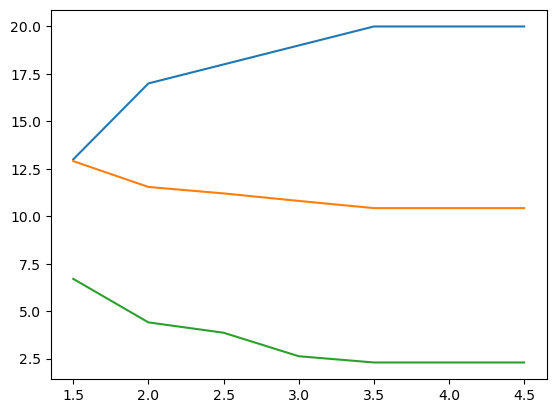

In [117]:
print(np.mean(Shapes), min(Shapes))
NShapes = Shapes.copy()
while min(NShapes)<np.mean(NShapes)/3:
    NShapes.pop(np.argmin(NShapes))

print(len(Shapes),len(NShapes),np.mean(NShapes),min(NShapes))

def ReduceMin(L,fact):
    NL = L.copy()
    while min(NL)<(np.mean(NL)/fact):
        NL.pop(np.argmin(NL))
    return len(NL),(np.mean(NL))/np.mean(L)*10, min(NL)/min(L)

X = [i/2 for i in range(3,10)]
Y = [ReduceMin(Shapes,x) for x in X]

plt.plot(X,Y)

In [118]:
DelNumb = 3

Data,Label = DataFrame.copy(),LabelFrame.copy()

Deletor = sorted([(i,Shapes[i]) for i in range(len(Shapes))],key=lambda x : x[1])[:DelNumb]
for j,k in sorted(Deletor,reverse=True):
    Label.pop(j)
    Data.pop(j)

#print(np.mean([d.shape[1] for d in Data]),min([d.shape[1] for d in Data]))

In [119]:
LABELS = np.array(Label)
LABELS.shape

(18, 4)

In [120]:
DATA = []

LSNb = min([d.shape[1] for d in Data])

for df in Data:
    Ndf = np.ndarray((3,LSNb))
    
    for j,d in enumerate(df) :
        Nbo = d.tolist()
        Indexes = rd.sample(range(len(Nbo)),LSNb)
        Nbn = [Nbo[i] for i in range(len(Nbo)) if i in Indexes]
        Ndf[j] = Nbn
    DATA.append(Ndf)
DATA = np.array(DATA)


## Transformation des données

In [121]:
Datatrain = [{"name":"Number" },{"name":"Speed"},{"name":"Excentricity"}]

PCASize = 15

TTS = rd.sample(range(len(DATA)),int(len(DATA)*(1-.2)))


for i in range(3):
    d = DATA[:,i,:]
    pca = PCA(PCASize)
    pca.fit(d)
    dt = pca.transform(d)

    Datatrain[i]["X_train"],Datatrain[i]["X_test"] = np.array([dt[i] for i in range(len(dt)) if i in TTS]), np.array([dt[i] for i in range(len(dt)) if i not in TTS]) #5464021513.2




In [122]:
Y_train,Y_test = np.array([LABELS[i] for i in range(len(LABELS)) if i in TTS]),np.array([LABELS[i] for i in range(len(LABELS)) if i not in TTS])

In [123]:
X_train,X_test = [list(Datatrain[0]['X_train'][i]/max(Datatrain[0]['X_train'][i]))+list(Datatrain[1]['X_train'][i]/max(Datatrain[1]['X_train'][i]))+list(Datatrain[2]['X_train'][i]/max(Datatrain[2]['X_train'][i])) for i in range(len(TTS))],[list(Datatrain[0]['X_test'][i])+list(Datatrain[1]['X_test'][i])+list(Datatrain[2]['X_test'][i]) for i in range(len(Datatrain[0]['X_test']))]

X_train,X_test = np.array(X_train), np.array(X_test)

# ANN

## initialisation

In [124]:
Organiques = ["octan1ol" , "pentan1ol" , "diethyle phtalate" , "acide octanoïque"]

Models_val = [0 for i in Organiques]

Histories = [None for i in Organiques]

In [125]:
Relu,Tan,Sig = Activation_Function(relu,relu_derivative,name='relu'),Activation_Function(tanh,tanh_derivative,name = 'tanh'),Activation_Function(sigmoid,sigmoid_derivative,name = 'sigmoid')

## Entraînement

In [135]:
from itertools import product
#np.random.seed(42)
# Hyperparameter ranges
i_size,o_size = PCASize*3,1 
epoch_options =[2000,4000]#[8000]## [8000, 10000,9000,7000]#, 30000], 35000, 40000]  # Possible values for epochs
learning_rate_options = [0.005, 0.001,0.0005]# 0.01, 0.05, 0.09, 0.1]  # Possible values for learning rates
momentum_options = [0.2, 0.6]  # Possible values for momentum
h_size_options = [3,6,32,64] #[6]
activation_options = [Sig,Relu]

N_hidden = 2
N_iter =  ((len(h_size_options)*len(activation_options))**N_hidden)*len(epoch_options)*len(learning_rate_options)*len(momentum_options)

# Store best parameters and scores for each orga
best_params = {}
best_scores = {}
Models = [0 for i in range(len(Organiques))]
# Perform grid search for each compound
for i, orga in enumerate(Organiques):
    print(f"\nTuning hyperparameters for organism: {orga}")
    
    best_params[orga] = None
    best_scores[orga] = -float('inf')#-float('inf')  # Use 'inf' because we are minimizing the loss
    #first = True
    # Grid search over all hyperparameter combinations
    iteration = 0
    for h_size1,h_size2, epochs, learning_rate, momentum,activation1,activation2 in product(h_size_options,h_size_options, epoch_options, learning_rate_options, momentum_options,activation_options,activation_options):
        clear_output(wait=True)
        Loading(iteration/N_iter)
        print(f"Testing combination for {orga}: Hiddens={h_size1,h_size2}, Epochs={epochs}, Learning Rate={learning_rate}, Momentum={momentum}, Activation={activation1.name,activation2.name}")
        iteration+=1
        #if first:
        rng = RandomState(42)
        #else:
        #rng = np.random
        # Initialize and train the model for the current orga
        model = Network(input_size=i_size, output_size=o_size, hidden_sizes=[h_size1,h_size2], Name=orga, random_state = rng,activations = [activation1,activation2])
        history = model.train(
            X_train,
            np.array([[Y_train[j][i]] for j in range(len(Y_train))]),
            epochs=epochs,
            learning_rate=learning_rate,
            momentum=momentum,
            Training_Info = False,
            train_steps=1000, 
            random_state = rng
        )
        # Evaluate the model on the validation set
        current_accuracy = Accuracy(model,X_test,np.array([[Y_test[j][i]] for j in range(len(Y_test))]))
        
        
            # Keep track of the best hyperparameters for this orga
        if current_accuracy > best_scores[orga]:
            best_scores[orga] = current_accuracy
            best_params[orga] = (epochs, learning_rate, momentum, [h_size1,h_size2],[activation1,activation2])
            Models[i] = model
            first = False
    print(f"Best Hyperparameters for {orga}: Epochs={best_params[orga][0]}, Learning Rate={best_params[orga][1]}, Momentum={best_params[orga][2]}, function={best_params[orga][4]}")
    print(f"Best Validation Loss for {orga}: {best_scores[orga]:.4f}")
    


[=================================================================================================== ]
Testing combination for acide octanoïque: Hiddens=(64, 64), Epochs=4000, Learning Rate=0.0005, Momentum=0.6, Activation=('relu', 'relu')
Best Hyperparameters for acide octanoïque: Epochs=2000, Learning Rate=0.0005, Momentum=0.2, function=[<__main__.Activation_Function object at 0x000001C75436F050>, <__main__.Activation_Function object at 0x000001C7555C1E10>]
Best Validation Loss for acide octanoïque: 0.5025


In [136]:
# Final results for all orgas
print("\nFinal Best Hyperparameters for Each Compound:")
for orga in Organiques:
    print(f"{orga}: Epochs={best_params[orga][0]}, Learning Rate={best_params[orga][1]}, Momentum={best_params[orga][2]}, Validation accuracy={best_scores[orga]:.4f}, h_size={best_params[orga][3]}, function={[f.name for f in best_params[orga][4]]}")



Final Best Hyperparameters for Each Compound:
octan1ol: Epochs=4000, Learning Rate=0.005, Momentum=0.6, Validation accuracy=0.7550, h_size=[3, 3], function=['sigmoid', 'relu']
pentan1ol: Epochs=2000, Learning Rate=0.005, Momentum=0.2, Validation accuracy=0.5050, h_size=[3, 64], function=['sigmoid', 'relu']
diethyle phtalate: Epochs=2000, Learning Rate=0.001, Momentum=0.2, Validation accuracy=0.7575, h_size=[3, 6], function=['sigmoid', 'sigmoid']
acide octanoïque: Epochs=2000, Learning Rate=0.0005, Momentum=0.2, Validation accuracy=0.5025, h_size=[3, 6], function=['relu', 'sigmoid']


# Résultats

In [137]:

predictions, = np.array([Nw.forward(X_test) for Nw in Models]).T  

i=0
for pred in predictions:
    print(str([round(pd,2) for pd in pred]) + "vs" + str(Y_test[i])) 
    i +=1

[np.float64(0.0), np.float64(0.16), np.float64(0.22), np.float64(0.2)]vs[0. 1. 0. 0.]
[np.float64(0.11), np.float64(0.23), np.float64(0.36), np.float64(0.4)]vs[0.125 0.125 0.375 0.375]
[np.float64(0.0), np.float64(0.16), np.float64(0.18), np.float64(0.22)]vs[0.17 0.17 0.17 0.49]
[np.float64(0.54), np.float64(0.16), np.float64(0.18), np.float64(0.18)]vs[0.49 0.17 0.17 0.17]


C:\Users\arthu\AppData\Local\Temp\ipykernel_5468\3540099519.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


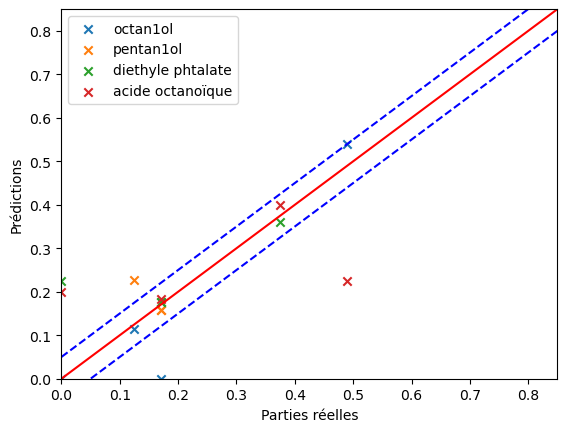

In [138]:
for i in range(len(predictions.T)):
    plt.scatter(Y_test.T[i],predictions.T[i], marker='x',label = Organiques[i])

x = np.linspace(0,1,100)

plt.plot(x,x, color = 'red')
plt.plot(x[2:],(x-0.05)[2:], '--b')
plt.plot(x,x+0.05, '--b')

plt.xlim(0,0.85)
plt.ylim(0,0.85)

plt.ylabel('Prédictions')
plt.xlabel('Parties réelles')

plt.legend()
plt.show()

# Essais de mon coté

In [130]:
i_size,o_size = PCASize*3,1 
epochs = 20000
learning_rate= 0.0005
momentum= 0.5
h_sizes=  [8,32]
activations= [Sig,Sig]

In [131]:
Models_pers = [0,0,0,0]
best_scores_pers = {}
Histories_perso = [0,0,0,0]

In [132]:
rng = RandomState(666)

for i, orga in enumerate(Organiques):
    model = Network(input_size=i_size, output_size=o_size, hidden_sizes=h_sizes, Name=orga, random_state = rng,activations = activations)
    history = model.train(
        X_train,
        np.array([[Y_train[j][i]] for j in range(len(Y_train))]),
        epochs=epochs,
        learning_rate=learning_rate,
        momentum=momentum,
        Training_Info = False,
        train_steps=1000, 
        random_state = rng
    )

    best_scores_pers[orga] = current_accuracy
    Models_pers[i] = model
    first = False
    Histories_perso[i] = history

print(best_scores_pers)

{'octan1ol': np.float64(0.0), 'pentan1ol': np.float64(0.0), 'diethyle phtalate': np.float64(0.0), 'acide octanoïque': np.float64(0.0)}


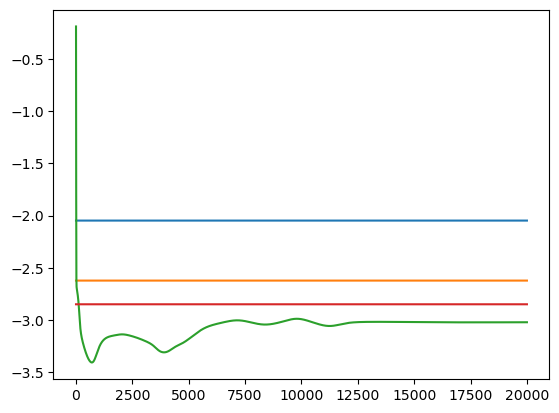

In [133]:
for h in Histories_perso:
    plt.plot(np.log(h))
plt.show()

C:\Users\arthu\AppData\Local\Temp\ipykernel_5468\3540099519.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[np.float64(0.0), np.float64(0.0), np.float64(0.22), np.float64(0.0)]vs[0. 1. 0. 0.]
[np.float64(0.0), np.float64(0.0), np.float64(0.39), np.float64(0.0)]vs[0.125 0.125 0.375 0.375]
[np.float64(0.0), np.float64(0.0), np.float64(0.22), np.float64(0.0)]vs[0.17 0.17 0.17 0.49]
[np.float64(0.0), np.float64(0.0), np.float64(0.22), np.float64(0.0)]vs[0.49 0.17 0.17 0.17]


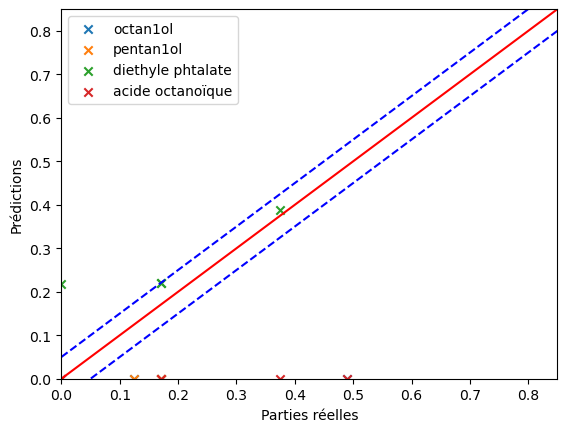

In [134]:

predictions_pers, = np.array([Nw.forward(X_test) for Nw in Models_pers]).T  

i=0
for pred in predictions_pers:
    print(str([round(pd,2) for pd in pred]) + "vs" + str(Y_test[i])) 
    i +=1

for i in range(len(predictions_pers.T)):
    plt.scatter(Y_test.T[i],predictions_pers.T[i], marker='x',label = Organiques[i])

x = np.linspace(0,1,100)

plt.plot(x,x, color = 'red')
plt.plot(x[2:],(x-0.05)[2:], '--b')
plt.plot(x,x+0.05, '--b')

plt.xlim(0,0.85)
plt.ylim(0,0.85)

plt.ylabel('Prédictions')
plt.xlabel('Parties réelles')

plt.legend()
plt.show()